<a href="https://colab.research.google.com/github/fuentes145/Tarea2/blob/main/parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Finetuning YOLOv5: ``You-Only-Look-Once"

# Actividad 4
Investigue sobre la arquitectura de los modelos YOLO y explique los siguientes conceptos (para cada
caso use solo 5 líneas máximo):


• Diferencia entre frameworks de detección de objetos de una y dos etapas (single-stage vs.
two-stage object detection).


• Función de pérdida Complete Intersection Over Union (CIoU) y su uso en la red YOLOv5.


• Función de pérdida Binary Cross Entropy (BCE) y su uso en la red YOLOv5.

• ¿Cómo se calcula la función de pérdida total en YOLOv5?



## 1. Single‑stage vs. Two‑stage object detection
- **Modelos de una etapa (single‑stage)**, como YOLO, *predicen directamente* bounding boxes + clases en un **único paso** sobre la imagen, obteniendo gran velocidad.
- **Modelos de dos etapas (two‑stage)**, como Faster R‑CNN, primero generan **regiones propuestas (RPN)** y luego **refinan y clasifican** cada propuesta.
- El enfoque de una etapa sacrifica algo de exactitud por latencia bajísima; el de dos etapas logra mejor mAP pero con mayor coste computacional.
- En tareas de *streaming* o tiempo real, la relación *precisión/velocidad* de YOLO lo hace preferible.

## 2. Pérdida Complete IoU (CIoU)
La métrica CIoU extiende la IoU clásica penalizando también la distancia entre centros y la discrepancia de aspecto:

$$
\text{CIoU}(b, b^{gt}) = \text{IoU}
- \frac{\rho^2(\mathbf{c}, \mathbf{c^{gt}})}{c^2}
- \alpha v
$$

con $\rho$ la distancia euclídea entre centros, $c$ la diagonal del cuadro mínimo que los contiene, $v$ la divergencia de relación ancho‑alto y $\alpha$ un término de equilibrio.

- CIoU es **diferenciable** y conduce a convergencia más estable que IoU o GIoU.
- YOLOv5 optimiza la posición de los *boxes* usando $L_\text{CIoU} = 1 - \text{CIoU}$.

## 3. Pérdida Binary Cross Entropy (BCE)
Para un ejemplo con etiqueta binaria $y \in \{0,1\}$ y probabilidad predicha $p$:

$$
\text{BCE}(p, y) = -\big(y \log p + (1 - y) \log(1 - p)\big)
$$

- En YOLOv5 hay **dos instancias** de BCE:
  1. **Objectness**: decide si existe objeto en cada celda‑ancla.
  2. **Clasificación**: distribuye probabilidad entre las $N$ clases (BCE por clase, activación sigmoid).
- BCE es adecuada para etiquetas escasas y balances asimétricos.

## 4. Función de pérdida total en YOLOv5
La red minimiza una suma ponderada de tres componentes:

$$
\mathcal{L}_\text{total}
= \lambda_{\text{box}}\,\mathcal{L}_{\text{CIoU}}
+ \lambda_{\text{obj}}\,\mathcal{L}_{\text{BCE,obj}}
+ \lambda_{\text{cls}}\,\mathcal{L}_{\text{BCE,cls}}
$$

- $\mathcal{L}_{\text{CIoU}}$ ajusta posición y tamaño de los *bounding boxes*.
- $\mathcal{L}_{\text{BCE,obj}}$ refuerza la correcta predicción de presencia de objeto.
- $\mathcal{L}_{\text{BCE,cls}}$ impulsa la clasificación de la clase.
- Los pesos $\lambda$ se afinan empíricamente, típicamente $\approx (0.05, 1.0, 0.5)$, para equilibrar localización y reconocimiento.

---



# Actividad 5
Investigue sobre el output de la red YOLOv5 y cómo se traduce el tensor de salida a bounding boxes
y detecciones de objetos. Además, explique cómo, en general, se obtiene solamente una detección
por objeto, y no varias para todas las regiones donde el objeto está presente. Además, investigue el
rol de la augmentación de datos en el entrenamiento de YOLOv5.


## 1. Decodificación del tensor de salida a *bounding boxes*
YOLOv5 produce un tensor de forma `(B, A*(5+C), H, W)` donde:
- *B* = batch, *A* = anclas por celda, *C* = número de clases, *H×W* = tamaño de la malla.
- Para cada ancla la red predice $\big(t_x,\,t_y,\,t_w,\,t_h,\,p_{obj},\,p_{cls,1\dots C}\big)$.

Las coordenadas se decodifican con
$$
\begin{aligned}
 x &= \frac{\sigma(t_x)+c_x}{W},\\
 y &= \frac{\sigma(t_y)+c_y}{H},\\
 w &= \frac{e^{t_w}\,a_w}{\text{img}_w},\\
 h &= \frac{e^{t_h}\,a_h}{\text{img}_h},
\end{aligned}
$$
donde $(c_x,c_y)$ son las coordenadas de la celda, $(a_w,a_h)$ las dimensiones del ancla y $\sigma$ la sigmoide. Así se obtienen *bounding boxes* normalizados $(x,y,w,h)$.

## 2. Una sola detección por objeto: *Non‑Max Suppression* (NMS)
- Después de decodificar, cada *box* lleva una confianza $p = \sigma(p_{obj})\max_j p_{cls,j}$.
- Se descartan boxes con $p$ bajo (threshold).
- Sobre los restantes se aplica **NMS**: se mantienen los boxes con mayor confianza y se eliminan los que tengan IoU $>\tau$ con alguno ya aceptado.
- YOLOv5 usa variantes como *CIoU‑NMS* o *Weighted NMS* según la versión, pero el principio es idéntico: una sola predicción por objeto.

## 3. Rol del aumento de datos (*data augmentation*)
El *augment* amplía la diversidad del set y mejora la generalización:
- **Geometría**: escalado, recorte, volteo, rotaciones (útiles cuando la orientación del satélite varía).
- **Color**: jitter HSV, blur, ruido.
- **Mosaic & MixUp**: combinan cuatro imágenes o mezclan pares, exponiendo múltiples objetos a cada contexto.
- Beneficios principales: reduce *overfitting*, mejora robustez ante variaciones de iluminación/escala y estabiliza el entrenamiento cuando los datos son escasos.

En YOLOv5 el módulo `Albumentations` (o la implementación interna de Ultralytics) integra estos *transforms* antes de pasar las imágenes por la red.


#Actividad 6
En el notebook, deberán hacer fine-tuning para que una instancia de YOLOv5 pueda realizar seg-
mentaciones de datos satelitales. Para esto, se encuentra implementado la carga del modelo YOLOv5

con los parámetros congelados salvo la cabeza de detección. Se encuentra además el código para
cargar y preprocesar el set de datos. Se deben completar las siguientes funciones:

In [1]:
!pip install roboflow
# Para cargar un dataset desde Roboflow
from roboflow import Roboflow
my_key = "hhJFVyqL27We1hzvzNAa"
rf = Roboflow(api_key=my_key)
project = rf.workspace("cvproject-y6bf4").project("vehicle-detection-gr77r")
version = project.version(1)
dataset = version.download("yolov5")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Vehicle-Detection-1 in yolov5pytorch:: 100%|██████████| 5528/5528 [00:01<00:00, 4726.26it/s]


In [2]:
# Instalar dependencias de YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
!pip install opencv-python
!pip install torchinfo
!wget https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt
%cd ..

Cloning into 'yolov5'...
remote: Enumerating objects: 17430, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 17430 (delta 73), reused 28 (delta 26), pack-reused 17327 (from 4)
Receiving objects: 100% (17430/17430), 16.31 MiB | 7.76 MiB/s, done.
Resolving deltas: 100% (11944/11944), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s 

In [3]:
import sys
sys.path.append('yolov5')
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms as T
from models.yolo import Model, Detect
import yaml
from utils.loss import ComputeLoss
from torchinfo import summary
import albumentations as A

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [19]:
# Dataset de YOLO

class YoloDataset(Dataset):
    def __init__(self, root, img_size=640, augment=False):
        self.image_dir = os.path.join(root, 'images')
        self.label_dir = os.path.join(root, 'labels')
        self.filenames = sorted(os.listdir(self.image_dir))[:2]
        self.img_size = img_size

        transforms =[
              A.Resize(img_size, img_size),
              A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
              A.ToTensorV2()
              ]
        if augment:
            # Completar con rotaciones
            aug_transforms = [
                A.RandomRotate90(p=0.5),  # Rotación de 90 grados
                A.Rotate(limit=30, p=0.7),  # Rotación aleatoria hasta 30 grados
                A.HorizontalFlip(p=0.5),    # Volteo horizontal
                A.RandomBrightnessContrast(p=0.2)  # Ajustes de brillo/contraste
            ]
            transforms = aug_transforms + transforms

        self.transform = A.Compose(transforms, bbox_params=A.BboxParams(
            format='yolo',  # Formato YOLO: [x_center, y_center, width, height]
            label_fields=['class_labels']
        ))
        self.yaml_path = '/' + os.path.join(*root.split('/')[:-1], 'data.yaml')
        with open(self.yaml_path, 'r') as f:
            self.yaml = yaml.safe_load(f)
        self.cls_to_idx = {cls: idx for idx, cls in enumerate(self.yaml['names'])}
        self.idx_to_cls = {idx: cls for idx, cls in enumerate(self.yaml['names'])}

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt').replace('.png', '.txt'))
        img = np.array(Image.open(img_path).convert('RGB'))
        labels = []
        classes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    vals = list(map(float, line.strip().split()))
                    if len(vals) >= 5:
                        cls, bbox = int(vals[0]), vals[1:5]
                        classes.append(cls)
                        labels.append(bbox)
        transformed = self.transform(image=img, bboxes=labels, class_labels=classes)
        img = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
        classes = torch.tensor(transformed['class_labels'], dtype=torch.float32).unsqueeze(1)
        if boxes.numel() > 0:
            labels = torch.cat([classes, boxes], dim=1)
        else:
            labels = torch.zeros((0, 5), dtype=torch.float32)

        return img, labels

    def __len__(self):
        return len(self.filenames)

# Convierte datos a formato YOLO
def collate_fn(batch):
    imgs, targets = [], []
    for i, (img, target) in enumerate(batch):
        imgs.append(img)
        target = torch.cat([torch.full((target.size(0), 1), i), target], dim=1)
        targets.append(target)

    imgs = torch.stack(imgs, dim=0)
    targets = torch.cat(targets, dim=0)

    return imgs, targets



In [20]:
import yaml
from models.yolo import Model

from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = YoloDataset('/content/Vehicle-Detection-1/train')

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn, num_workers = 2)


model = torch.hub.load("ultralytics/yolov5", "yolov5s", classes=len(train_dataset.yaml['names']), pretrained=True, autoshape=False).cpu()
hyp_path = '/content/yolov5/data/hyps/hyp.scratch-low.yaml'

with open(hyp_path) as f:
    hyp = yaml.safe_load(f)

# Congelar modelo
for param in model.parameters():
    param.requires_grad = False

# Descongelar cabeza
for param in model.model[-1].parameters():
    param.requires_grad = True

model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.hyp = hyp


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-416-gfe1d4d99 Python-3.11.12 torch-2.6.0+cu124 CPU

Overriding model.yaml nc=80 with nc=4

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        

In [21]:
from utils.loss import ComputeLoss

def train(model, dataloader, optimizer, epochs):
    model.train()
    compute_loss = ComputeLoss(model)
    history = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_box_loss = 0
        epoch_obj_loss = 0
        epoch_cls_loss = 0

        for batch_i, (imgs, targets) in enumerate(dataloader):
            imgs = imgs.to(device)
            targets = targets.to(device)

            pred = model(imgs)
            loss, loss_items = compute_loss(pred, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.item()
            epoch_box_loss += loss_items[0].item()
            epoch_obj_loss += loss_items[1].item()
            epoch_cls_loss += loss_items[2].item()

        avg_loss = epoch_loss / len(dataloader)
        avg_box_loss = epoch_box_loss / len(dataloader)
        avg_obj_loss = epoch_obj_loss / len(dataloader)
        avg_cls_loss = epoch_cls_loss / len(dataloader)

        history.append({
            'epoch': epoch + 1,
            'loss': avg_loss,
            'box_loss': avg_box_loss,
            'obj_loss': avg_obj_loss,
            'cls_loss': avg_cls_loss
        })

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Box: {avg_box_loss:.4f}, Obj: {avg_obj_loss:.4f}, Cls: {avg_cls_loss:.4f}")

    return model, history

def eval(model, dataloader, conf_thres=0.25, iou_thres=0.45):
    model.eval()

    stats = {
        'images_processed': 0,
        'total_detections': 0,
        'detections_by_class': {},
        'avg_confidence': 0,
    }

    with torch.no_grad():
        for batch_i, (imgs, targets) in enumerate(dataloader):
            imgs = imgs.to(device)

            output = model(imgs)
            detections = output[0]

            conf_mask = detections[..., 4] > conf_thres
            detections = detections[conf_mask]

            stats['images_processed'] += imgs.shape[0]

            if detections.shape[0] > 0:
                stats['total_detections'] += detections.shape[0]
                stats['avg_confidence'] += detections[:, 4].sum().item()

                for cls in detections[:, 5].cpu().numpy():
                    cls_idx = int(cls)
                    cls_name = train_dataset.idx_to_cls.get(cls_idx, f"class_{cls_idx}")
                    stats['detections_by_class'][cls_name] = stats['detections_by_class'].get(cls_name, 0) + 1

    if stats['total_detections'] > 0:
        stats['avg_confidence'] /= stats['total_detections']

    return stats

In [22]:
# Configuración del optimizador
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.0001,
    weight_decay=5e-4
)

# Datasets
train_dataset = YoloDataset('/content/Vehicle-Detection-1/train')
val_dataset = YoloDataset('/content/Vehicle-Detection-1/valid')

# Dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

# Entrenamiento
trained_model, history = train(model, train_loader, optimizer, epochs=5)

# Evaluación
eval_stats = eval(trained_model, val_loader)

# Guardar modelo
torch.save(trained_model.state_dict(), 'yolov5_finetuned.pt')

Epoch 1/5 - Loss: 2.2375, Box: 0.1185, Obj: 0.0306, Cls: 0.9696
Epoch 2/5 - Loss: 2.2182, Box: 0.1177, Obj: 0.0304, Cls: 0.9610
Epoch 3/5 - Loss: 2.1991, Box: 0.1169, Obj: 0.0303, Cls: 0.9523
Epoch 4/5 - Loss: 2.1800, Box: 0.1160, Obj: 0.0302, Cls: 0.9438
Epoch 5/5 - Loss: 2.1612, Box: 0.1152, Obj: 0.0301, Cls: 0.9353


## Actividad 7
Finalmente, realice fine-tuning de dos modelos YOLOv5: uno sin transformaciones de datos adicionales y otro utilizando rotaciones, es decir, aplicando aumento de datos a partir de versiones

rotadas de las imágenes originales. ¿Se observa alguna diferencia notable en su rendimiento? ¿Por
qué las rotaciones constituyen una buena estrategia de aumento de datos para este problema?
Elija 3 imágenes representativas del set de validación y muestre los bounding boxes encontrados por
cada modelo.

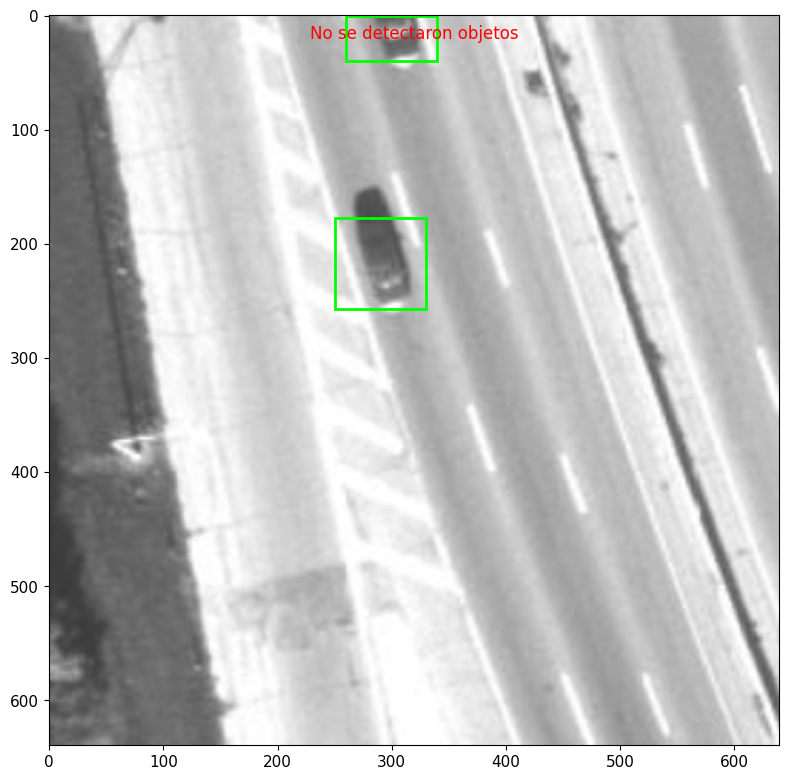

In [28]:
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torchvision.ops import nms

#model.load_state_dict(torch.load('yolov5s_finetuned.pt'))
%matplotlib inline

# Set model to eval
model.eval().to(device)

# Get one test sample
img_tensor, labels = train_dataset[0] # image: [3, H, W], labels: [N, 5]
img_np = img_tensor.permute(1, 2, 0).numpy()
H, W = img_np.shape[:2]

# Set up plot
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.imshow(img_np)
# ax.set_title("Ground Truth (Green) vs Predictions (Red)")

# # ---- Plot Ground Truth ----
for label in labels:
    cls = int(label[0].item())
    x_center, y_center, width, height = label[1:] * torch.tensor([W, H, W, H])
    x1 = (x_center - width / 2).item()
    y1 = (y_center - height / 2).item()

    # Rectangle for ground truth
    rect = Rectangle((x1, y1), width.item(), height.item(),
                     linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)

# ---- Predictions ----

# Completar
# ---- Predictions ----

# Obtener predicciones del modelo
# Obtener predicciones del modelo
with torch.no_grad():
    model.eval()
    img_batch = img_tensor.unsqueeze(0).to(device)  # Añadir dimensión de batch
    predictions = model(img_batch)

# Para YOLOv5, la salida tiene forma [batch, detections, features]
pred = predictions[0]  # Primera salida del modelo

# Acceder a las predicciones correctamente - tenemos que ajustar las dimensiones
if len(pred.shape) == 3:  # Si tiene forma [batch, detections, features]
    # Trabajar con el primer elemento del batch
    pred = pred.squeeze(0)  # Ahora tiene forma [detections, features]

# Ahora aplicar filtro de confianza
conf_threshold = 0.25
conf_mask = pred[:, 4] > conf_threshold
pred = pred[conf_mask]

 # Extraer predicciones del batch

# Aplicar filtro de confianza
conf_threshold = 0.25
conf_mask = pred[:, 4] > conf_threshold
pred = pred[conf_mask]

# Aplicar NMS para eliminar detecciones redundantes
iou_threshold = 0.45
if len(pred) > 0:
    # Convertir de formato YOLO (center_x, center_y, width, height) a xyxy para NMS
    boxes = pred[:, :4].clone()  # x, y, w, h formato
    scores = pred[:, 4]
    keep_indices = nms(boxes, scores, iou_threshold)
    pred = pred[keep_indices]

# Dibujar las predicciones
if len(pred) > 0:
    for detection in pred:
        x_center, y_center, width, height = detection[:4]
        conf = detection[4].item()
        cls_idx = int(detection[5].item())
        cls_name = train_dataset.idx_to_cls.get(cls_idx, f"class_{cls_idx}")

        # Convertir a coordenadas de píxeles
        x_center, y_center = x_center * W, y_center * H
        width, height = width * W, height * H

        # Calcular esquina superior izquierda
        x1 = (x_center - width / 2).item()
        y1 = (y_center - height / 2).item()

        # Dibujar rectángulo para predicción
        rect = Rectangle((x1, y1), width.item(), height.item(),
                        linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Añadir etiqueta con clase y confianza
        label_text = f"{cls_name}: {conf:.2f}"
        ax.text(x1, y1-5, label_text, color='white', fontsize=8,
                bbox=dict(facecolor='red', alpha=0.5))
else:
    ax.text(W/2, 20, "No se detectaron objetos", color='red', fontsize=12,
           horizontalalignment='center')

# Mostrar figura
plt.tight_layout()

In [ ]:
# Actividad 7: Comparación de modelos con y sin aumento de datos

# 1. Crear datasets para entrenamiento con y sin aumento
train_dataset_no_aug = YoloDataset('/content/Vehicle-Detection-1/train', augment=False)
train_dataset_with_aug = YoloDataset('/content/Vehicle-Detection-1/train', augment=True)
val_dataset = YoloDataset('/content/Vehicle-Detection-1/valid', augment=False)

# 2. Crear dataloaders
train_loader_no_aug = DataLoader(
    train_dataset_no_aug,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

train_loader_with_aug = DataLoader(
    train_dataset_with_aug,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2
)

# 3. Inicializar el primer modelo (sin aumento)
model_no_aug = torch.hub.load("ultralytics/yolov5", "yolov5s",
                              classes=len(train_dataset_no_aug.yaml['names']),
                              pretrained=True, autoshape=False).cpu()

# Congelar todas las capas excepto la cabeza
for param in model_no_aug.parameters():
    param.requires_grad = False
for param in model_no_aug.model[-1].parameters():
    param.requires_grad = True

model_no_aug = model_no_aug.to(device)
model_no_aug.hyp = hyp

optimizer_no_aug = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_no_aug.parameters()),
    lr=0.0001,
    weight_decay=5e-4
)

# 4. Entrenar modelo sin aumento
print("Entrenando modelo sin aumento de datos:")
model_no_aug, history_no_aug = train(model_no_aug, train_loader_no_aug, optimizer_no_aug, epochs=5)
torch.save(model_no_aug.state_dict(), 'yolov5_no_aug.pt')

# 5. Inicializar el segundo modelo (con aumento)
model_with_aug = torch.hub.load("ultralytics/yolov5", "yolov5s",
                               classes=len(train_dataset_with_aug.yaml['names']),
                               pretrained=True, autoshape=False).cpu()

# Congelar todas las capas excepto la cabeza
for param in model_with_aug.parameters():
    param.requires_grad = False
for param in model_with_aug.model[-1].parameters():
    param.requires_grad = True

model_with_aug = model_with_aug.to(device)
model_with_aug.hyp = hyp

optimizer_with_aug = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_with_aug.parameters()),
    lr=0.0001,
    weight_decay=5e-4
)

# 6. Entrenar modelo con aumento
print("Entrenando modelo con aumento de datos (rotaciones):")
model_with_aug, history_with_aug = train(model_with_aug, train_loader_with_aug, optimizer_with_aug, epochs=5)
torch.save(model_with_aug.state_dict(), 'yolov5_with_aug.pt')

# 7. Evaluar ambos modelos en el conjunto de validación
print("Evaluando modelo sin aumento:")
stats_no_aug = eval(model_no_aug, val_loader)
print(stats_no_aug)

print("Evaluando modelo con aumento:")
stats_with_aug = eval(model_with_aug, val_loader)
print(stats_with_aug)

# 8. Función para visualizar y comparar detecciones
def visualize_comparison(img_idx):
    """
    Visualiza y compara las predicciones de ambos modelos en una imagen
    """
    img_tensor, labels = val_dataset[img_idx]
    img_np = img_tensor.permute(1, 2, 0).numpy()
    H, W = img_np.shape[:2]

    # Normalizar imagen si es necesario
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Títulos para cada subgráfico
    titles = ["Modelo sin aumento", "Modelo con rotaciones"]
    models = [model_no_aug, model_with_aug]

    for i, (ax, model, title) in enumerate(zip(axes, models, titles)):
        ax.imshow(img_np)
        ax.set_title(title)

        # Dibujar ground truth (verde)
        for label in labels:
            cls = int(label[0].item())
            cls_name = val_dataset.idx_to_cls.get(cls, f"class_{cls}")
            x_center, y_center, width, height = label[1:] * torch.tensor([W, H, W, H])
            x1 = (x_center - width / 2).item()
            y1 = (y_center - height / 2).item()

            # Rectángulo para ground truth
            rect = Rectangle((x1, y1), width.item(), height.item(),
                             linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-5, cls_name, color='white', fontsize=8,
                    bbox=dict(facecolor='green', alpha=0.5))

        # Obtener predicciones
        with torch.no_grad():
            model.eval()
            img_batch = img_tensor.unsqueeze(0).to(device)
            predictions = model(img_batch)
            pred = predictions[0].cpu()

        # Filtrar predicciones por confianza
        conf_threshold = 0.25
        conf_mask = pred[:, 4] > conf_threshold
        pred = pred[conf_mask]

        # Dibujar predicciones (rojo)
        for detection in pred:
            x_center, y_center, width, height = detection[:4]
            conf = detection[4].item()
            cls_idx = int(detection[5].item())
            cls_name = val_dataset.idx_to_cls.get(cls_idx, f"class_{cls_idx}")

            # Convertir a coordenadas de píxeles
            x_center, y_center = x_center * W, y_center * H
            width, height = width * W, height * H
            x1 = (x_center - width / 2).item()
            y1 = (y_center - height / 2).item()

            # Rectángulo para predicción
            rect = Rectangle((x1, y1), width.item(), height.item(),
                             linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1+height.item()+5, f"{cls_name}: {conf:.2f}",
                    color='white', fontsize=8,
                    bbox=dict(facecolor='red', alpha=0.5))

    plt.tight_layout()
    plt.savefig(f'comparison_image_{img_idx}.png')
    plt.show()

# 9. Visualizar 3 imágenes representativas
print("Visualizando comparaciones en imágenes representativas:")
for idx in [0, 5, 10]:  # Puedes ajustar estos índices según necesites
    if idx < len(val_dataset):
        print(f"Imagen {idx}:")
        visualize_comparison(idx)